In [37]:
# Objectif : Importer les bibliothèques nécessaires à l’analyse exploratoire.
# Pourquoi ? Pandas permet la manipulation des données, NumPy le calcul numérique, et Matplotlib/Seaborn la visualisation.
# Résultat : L’environnement est prêt pour charger et analyser les données.


# 1/ Préparation de l’environnement

import warnings
warnings.filterwarnings("ignore")

# Imports des librairies nécessaires avant modélisation


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    precision_recall_curve,
    average_precision_score
)
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import shap

In [38]:
# 2/ Chargement des données brutes

# Objectif : Charger les fichiers bruts (SIRH, Evaluation, Survey) et examiner leur structure.
# Pourquoi ? Comprendre la dimension, les colonnes et les types de données avant toute transformation.
# Résultat : Les trois fichiers contiennent chacun 1470 lignes, ce qui permet un merge cohérent.

df = pd.read_csv("../data/df_clean.csv")
print(df.shape)
df.head()

(1470, 32)


,age,genre,revenu_mensuel,statut_marital,departement,poste,nombre_experiences_precedentes,nombre_heures_travailless,annee_experience_totale,annees_dans_l_entreprise,...,nombre_employee_sous_responsabilite,code_sondage,distance_domicile_travail,niveau_education,domaine_etude,ayant_enfants,frequence_deplacement,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel,has_left
0,41,F,5993,Célibataire,Commercial,Cadre Commercial,8,80,8,6,...,1,1,1,2,Infra & Cloud,Y,Occasionnel,0,5,1
1,49,M,5130,Marié(e),Consulting,Assistant de Direction,1,80,10,10,...,1,2,8,1,Infra & Cloud,Y,Frequent,1,7,0
2,37,M,2090,Célibataire,Consulting,Consultant,6,80,7,0,...,1,4,2,2,Autre,Y,Occasionnel,0,0,1
3,33,F,2909,Marié(e),Consulting,Assistant de Direction,1,80,8,8,...,1,5,3,4,Infra & Cloud,Y,Frequent,3,0,0
4,27,M,3468,Marié(e),Consulting,Consultant,9,80,6,2,...,1,7,2,1,Transformation Digitale,Y,Occasionnel,2,2,0


In [39]:
# 3/ Chargement des données brutes

# Objectif : Uniformiser les noms de colonnes (minuscules, suppression des espaces).
# Pourquoi ? Éviter les erreurs lors des merges et garantir une cohérence dans le code.
# Résultat : Les noms de colonnes sont propres et standardisés.

df.columns = df.columns.str.lower().str.strip().str.replace(" ", "_")

In [40]:
# 4/ Nettoyage des colonnes

# Objectif : Fusionner les trois datasets en un seul DataFrame central.
# Pourquoi ? La modélisation nécessite un dataset unique regroupant toutes les variables explicatives et la cible.
# Résultat : Le DataFrame final contient 1470 lignes et 34 colonnes.

df.columns = df.columns.str.lower().str.strip().str.replace(" ", "_")

In [41]:
# 5/ Création du DataFrame central

# Objectif : Fusionner les trois datasets en un seul DataFrame central.
# Pourquoi ? La modélisation nécessite un dataset unique regroupant toutes les variables explicatives et la cible.
# Résultat : Le DataFrame final contient 1470 lignes et 34 colonnes.

y = df["has_left"]
X = df.drop("has_left", axis=1)

In [42]:
# 6/ Identification des variables pertinentes

# Objectif : Identifier les variables numériques et catégorielles du dataset.
# Pourquoi ? Séparer les types de variables est essentiel pour appliquer les bons traitements (scaling pour les numériques, encodage pour les catégorielles).
# Résultat : Les variables numériques et catégorielles sont listées, ce qui permettra de construire des pipelines adaptés pour la modélisation.

num_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_features = X.select_dtypes(include=["object"]).columns.tolist()

print("Numériques :", num_features)
print("Catégorielles :", cat_features)

Numériques : ['age', 'revenu_mensuel', 'nombre_experiences_precedentes', 'nombre_heures_travailless', 'annee_experience_totale', 'annees_dans_l_entreprise', 'annees_dans_le_poste_actuel', 'satisfaction_employee_environnement', 'note_evaluation_precedente', 'niveau_hierarchique_poste', 'satisfaction_employee_nature_travail', 'satisfaction_employee_equipe', 'satisfaction_employee_equilibre_pro_perso', 'note_evaluation_actuelle', 'nombre_participation_pee', 'nb_formations_suivies', 'nombre_employee_sous_responsabilite', 'code_sondage', 'distance_domicile_travail', 'niveau_education', 'annees_depuis_la_derniere_promotion', 'annes_sous_responsable_actuel']
Catégorielles : ['genre', 'statut_marital', 'departement', 'poste', 'heure_supplementaires', 'augementation_salaire_precedente', 'domaine_etude', 'ayant_enfants', 'frequence_deplacement']


In [43]:
# 7/ Stratification des données

# Objectif : Séparer les données en jeu d'entraînement et de test tout en conservant la proportion des classes.
# Pourquoi ? La stratification permet de maintenir le déséquilibre naturel du dataset dans les deux ensembles.
# Résultat : Les données sont divisées en 80% entraînement et 20% test, avec une distribution de la cible identique dans chaque sous-ensemble.

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [44]:
# 8/ Préparation des données pour modélisation

# Objectif : Mettre en place un pipeline de prétraitement pour les variables numériques et catégorielles.
# Pourquoi ? Les variables numériques doivent être standardisées (StandardScaler) afin d’éviter qu’une variable avec de grandes valeurs domine le modèle.  Les variables catégorielles sont conservées pour être encodées ensuite dans le pipeline complet.
#Résultat : Un `ColumnTransformer` est créé pour appliquer les transformations adaptées à chaque type de variable.

numeric_pipeline = Pipeline([
    ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, num_features),
    ("cat", "passthrough", cat_features)
])

In [45]:
# 9/ Modèle étalon – DummyClassifier

# Objectif : Créer un modèle de référence simple (baseline).
# Pourquoi ? Le DummyClassifier prédit toujours la classe majoritaire.  Il permet de vérifier que nos futurs modèles font mieux qu’une prédiction naïve.
# Résultat : Le score obtenu (~0.84) correspond à la proportion de la classe majoritaire, confirmant le déséquilibre du dataset.

dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)

print("Dummy score :", dummy.score(X_test, y_test))

Dummy score : 0.8401360544217688


In [46]:
# 10/ Modèle linéaire interprétable – Régression Logistique

# Objectif : Entraîner un modèle de régression logistique pour prédire le turnover.
# Pourquoi ? La régression logistique est un modèle linéaire interprétable qui permet d’analyser l’influence de chaque variable sur la probabilité de départ.
#Résultat : Le modèle est entraîné sur les données prétraitées et produit des prédictions sur le jeu de test.

from sklearn.preprocessing import OneHotEncoder

numeric_pipeline = Pipeline([
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline([
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, num_features),
    ("cat", categorical_pipeline, cat_features)
    

])

log_model = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

log_model.fit(X_train, y_train)

y_pred_log = log_model.predict(X_test)

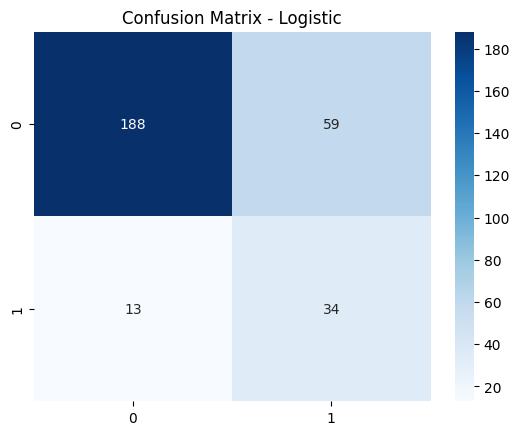

In [47]:
# 11/ Matrice de confusion – Logistique

#Objectif : Évaluer les performances du modèle à l’aide d’une matrice de confusion.
# Pourquoi ? La matrice de confusion permet d’analyser les vrais positifs, faux positifs, vrais négatifs et faux négatifs.
# Résultat : On observe la capacité du modèle à détecter les employés quittant l’entreprise (classe 1).

cm = confusion_matrix(y_test, y_pred_log)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Logistic")
plt.show()

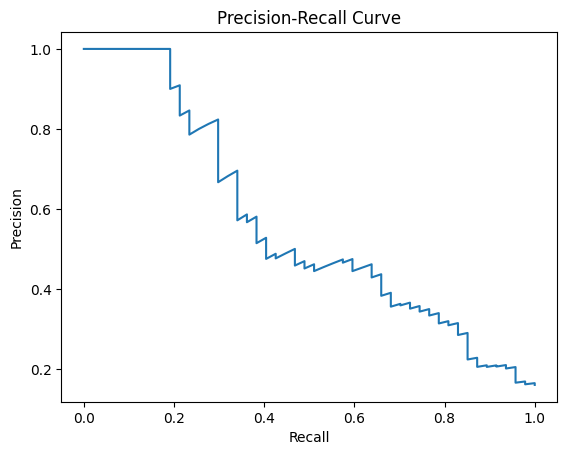

In [48]:
# 12/ Courbe Precision–Recall

# Objectif : Visualiser le compromis entre précision et rappel.
# Pourquoi ? Dans un contexte déséquilibré, la courbe Precision–Recall est plus pertinente que l’accuracy.
# Résultat : La courbe montre comment évolue la performance selon le seuil de décision.

y_scores = log_model.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

In [49]:
# 13/ Modèle non linéaire — RandomForest + SMOTE

#Objectif : Entraîner un modèle plus puissant (Random Forest) avec gestion du déséquilibre via SMOTE.
#Pourquoi ?RandomForest capture des relations non linéaires.SMOTE permet de rééquilibrer les classes en générant artificiellement des exemples de la classe minoritaire.
#Résultat : Le modèle non linéaire est entraîné sur des données équilibrées.

rf_pipeline = ImbPipeline([
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("model", RandomForestClassifier(
        n_estimators=300,
        class_weight="balanced",
        random_state=42
    ))
])

rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)

In [ ]:
# 14 / Stratification dans la validation croisée

# Objectif : Évaluer la stabilité du modèle via validation croisée stratifiée.
# Pourquoi ?  La stratification conserve la proportion des classes dans chaque fold. Cela permet d’obtenir une estimation robuste des performances.
# Résultat : On obtient une moyenne et un écart-type du recall, indiquant la stabilité du modèle.


scores = cross_val_score(
    best_log,
    X,
    y,
    cv=cv,
    scoring="recall"
)

In [ ]:
# 15 / Comparaison des 3 modèles


#Objectif :  Comparer les performances des trois modèles utilisés.
# Pourquoi ?  Cela permet d’identifier le modèle le plus performant selon plusieurs métriques adaptées au déséquilibre.
# Résultat : La Régression Logistique présente le meilleur recall, ce qui est cohérent avec l’objectif métier de minimiser les faux négatifs.

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# Prédictions
y_pred_dummy = dummy.predict(X_test)
y_pred_log = log_model.predict(X_test)
y_pred_rf = rf_pipeline.predict(X_test)

# Création du tableau comparatif
results = pd.DataFrame({
    "Modèle": ["Dummy", "Régression Logistique", "Random Forest"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_dummy),
        accuracy_score(y_test, y_pred_log),
        accuracy_score(y_test, y_pred_rf)
    ],
    "Precision": [
        precision_score(y_test, y_pred_dummy),
        precision_score(y_test, y_pred_log),
        precision_score(y_test, y_pred_rf)
    ],
    "Recall": [
        recall_score(y_test, y_pred_dummy),
        recall_score(y_test, y_pred_log),
        recall_score(y_test, y_pred_rf)
    ],
    "F1-score": [
        f1_score(y_test, y_pred_dummy),
        f1_score(y_test, y_pred_log),
        f1_score(y_test, y_pred_rf)
    ]
})

results

,Modèle,Accuracy,Precision,Recall,F1-score
0,Dummy,0.840136,0.000000,0.000000,0.000000
1,Régression Logistique,0.755102,0.365591,0.723404,0.485714
2,Random Forest,0.857143,0.647059,0.234043,0.343750


<Figure size 640x480 with 0 Axes>

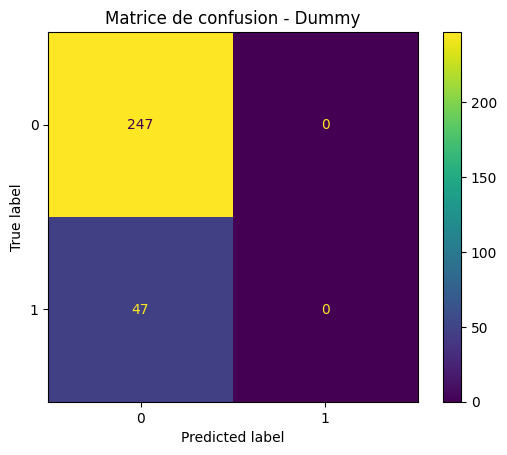

<Figure size 640x480 with 0 Axes>

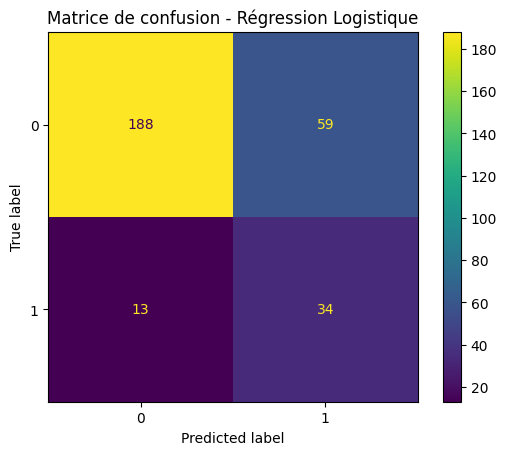

<Figure size 640x480 with 0 Axes>

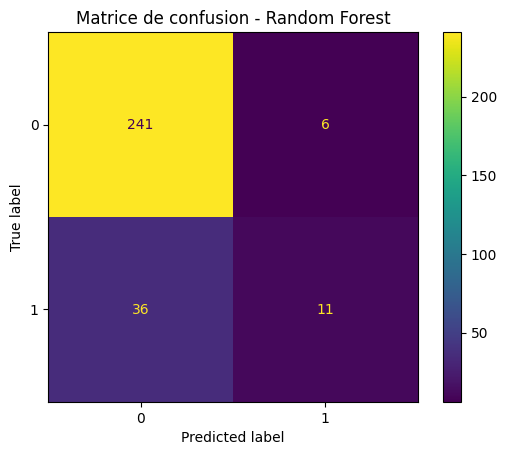

In [ ]:
# 16/ Matrice de confusion pour chaque modèle

# Objectif : Visualiser les erreurs de classification pour chaque modèle.
# Pourquoi ? La matrice de confusion permet d’analyser la capacité des modèles à détecter correctement les départs (classe 1).
# Résultat : La Régression Logistique présente un meilleur recall sur la classe 1, donc moins de faux négatifs, ce qui est cohérent avec l’objectif métier.

from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

models = {
    "Dummy": dummy,
    "Régression Logistique": log_model,
    "Random Forest": rf_pipeline
}

for name, model in models.items():
    plt.figure()
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
    plt.title(f"Matrice de confusion - {name}")
    plt.show()

In [ ]:

# 17/ Évaluation du modèle optimisé — Régression Logistique

# Objectif : Optimiser les hyperparamètres de la Régression Logistique via GridSearchCV.
# Pourquoi ? Les performances d’un modèle dépendent de ses paramètres (ici C). Le GridSearch utilise une validation croisée (5 folds) 
# sur les données d’entraînement afin de sélectionner la configuration maximisant le recall, sans utiliser le jeu de test.
# Résultat : Les meilleurs hyperparamètres sont identifiés selon la métrique métier.
from sklearn.model_selection import GridSearchCV

param_grid = {
    "model__C": [0.01, 0.1, 1, 10],
    "model__penalty": ["l2"],  
    "model__solver": ["lbfgs"] 
}

grid_search_log = GridSearchCV(
    log_model,
    param_grid,
    cv=5,
    scoring="recall",
    n_jobs=-1
)

grid_search_log.fit(X_train, y_train)

print("Meilleurs paramètres :", grid_search_log.best_params_)
print("Meilleur recall CV :", grid_search_log.best_score_)

Meilleurs paramètres : {'model__C': 0.01, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
Meilleur recall CV : 0.7684210526315789


In [ ]:
# 18/ Évaluation du modèle optimisé — Régression Logistique

# Objectif : Évaluer les performances du meilleur modèle sélectionné via GridSearchCV.
# Pourquoi ? Le GridSearch identifie la meilleure combinaison d’hyperparamètres en validation croisée selon la métrique métier (recall). 
# Il est ensuite nécessaire de tester ce modèle optimisé sur le jeu de test 
# pour mesurer sa performance sur des données jamais vues.
# Résultat : Le classification_report affiche les métriques clés (precision, recall, F1-score). Une attention particulière est portée 
# au recall de la classe 1, car l’objectif est de minimiser les faux négatifs (départs non détectés).



best_log = grid_search_log.best_estimator_

y_pred_best_log = best_log.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_best_log))

              precision    recall  f1-score   support

           0       0.94      0.77      0.84       247
           1       0.37      0.72      0.49        47

    accuracy                           0.76       294
   macro avg       0.65      0.75      0.67       294
weighted avg       0.85      0.76      0.79       294



In [ ]:
# 19/ Préparation pour interprétabilité

# Objectif : Utiliser exactement le même preprocessing que le pipeline.
# Pourquoi ? SHAP doit recevoir les données transformées identiquement à celles utilisées lors de l'entraînement.
# Résultat : On récupère les features transformées du preprocessor.

preprocessor = best_log.named_steps["preprocessor"]
X_train_transformed = preprocessor.transform(X_train)
feature_names = preprocessor.get_feature_names_out()

In [ ]:
# 20/ Entraînement modèle dédié SHAP

# Objectif : Utiliser le modèle final sélectionné (Régression Logistique optimisée)
# Pourquoi ? L’interprétation doit porter sur le modèle réellement retenu.
# Résultat : On récupère le modèle optimisé issu du GridSearch.

model_interpret = best_log.named_steps["model"]

In [ ]:
# 21/ Création explainer SHAP

# Objectif : Créer un explainer SHAP pour la Régression Logistique optimisée
# Pourquoi ? Analyser l’impact des variables sur les prédictions du modèle final.
# Résultat : Calcul des valeurs SHAP pour l’interprétation globale et locale.

import shap

explainer = shap.LinearExplainer(model_interpret, X_train_transformed)
shap_values = explainer(X_train_transformed)

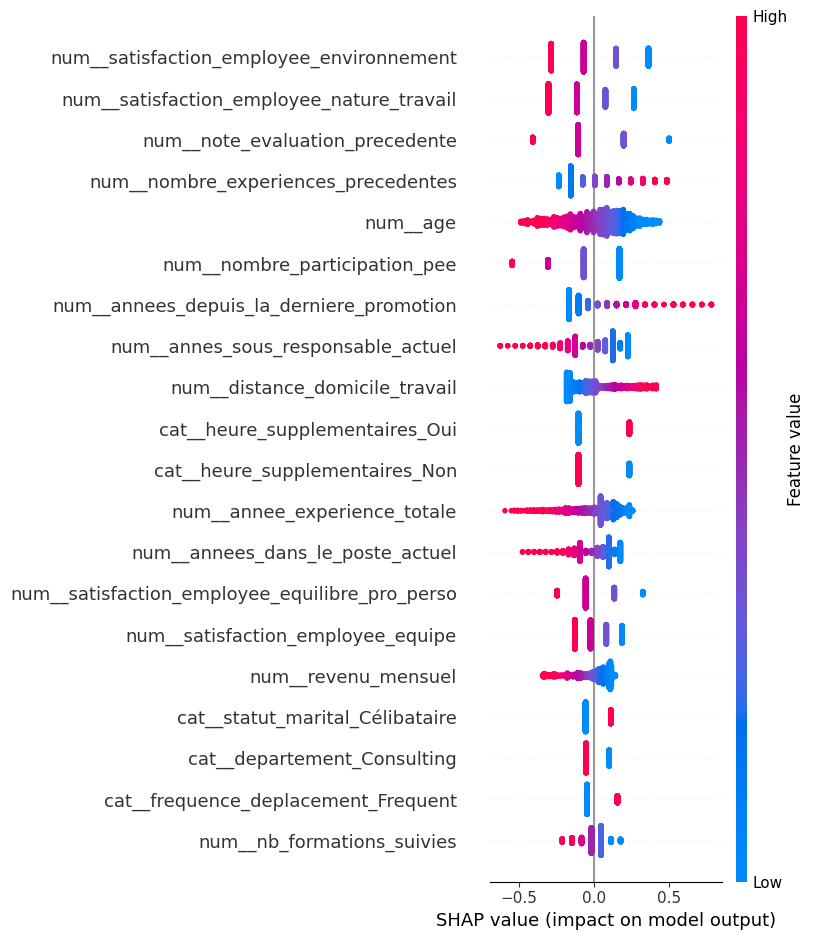

In [ ]:
# 22/ Summary plot global (feature importance)

shap.summary_plot(
    shap_values,
    X_train_transformed,
    feature_names=feature_names
)

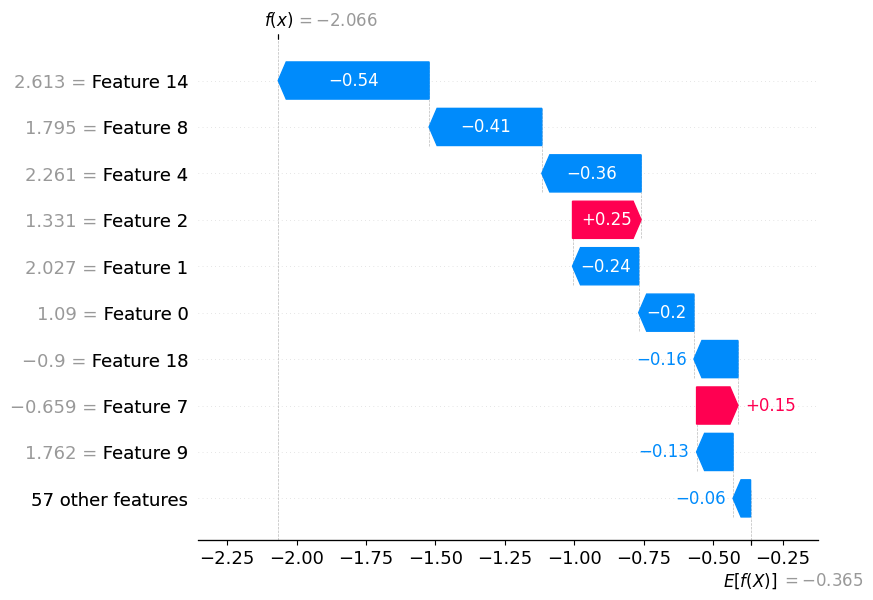

In [ ]:
# 23/ Individu analysé

shap.plots.waterfall(shap_values[0])

In [ ]:
# 24/ Validation croisée – moyenne & écart-type

# Objectif : Évaluer la robustesse du modèle via validation croisée.
# Pourquoi ? Cela permet de vérifier que les performances ne dépendent pas d’un seul découpage train/test.
# Résultat : On obtient une moyenne et un écart-type des métriques, indiquant la stabilité du modèle.

print("Validation croisée moyenne :", scores.mean())
print("Validation croisée std :", scores.std())

Validation croisée moyenne : 0.299645390070922
Validation croisée std : 0.048883625042995725
